In [1]:
import pandas as pd
import altair as alt

# Load your dataset (replace 'your_data.csv' with actual file)
aid = pd.read_csv('us_foreign_aid_complete.csv')

# Clean 'Fiscal Year' column
aid['Fiscal Year'] = pd.to_numeric(aid['Fiscal Year'], errors='coerce')
aid = aid.dropna(subset=['Fiscal Year'])
aid['Fiscal Year'] = aid['Fiscal Year'].astype(int)

selected_columns = [
    'Country ID', 'Country Code', 'Country Name', 'Region ID', 'Region Name', 
    'Income Group ID', 'Income Group Name', 'International Category ID', 'International Category Name',
    'International Sector Code', 'International Sector Name', 'International Purpose Code', 'International Purpose Name',
    'US Category ID', 'US Category Name', 'US Sector ID', 'US Sector Name', 'Foreign Assistance Objective ID',
    'Foreign Assistance Objective Name', 'Aid Type Group ID', 'Aid Type Group Name', 'Activity ID', 'Submission ID',
    'Activity Name', 'Activity Description', 'Activity Project Number', 'Activity Start Date', 'Activity End Date',
    'Transaction Type ID', 'Transaction Type Name', 'Fiscal Year', 'Transaction Date', 'Current Dollar Amount', 
    'Constant Dollar Amount', 'aid_type_id', 'aid_type_name', 'activity_budget_amount', 'submission_activity_id'
]

aid2 = aid[selected_columns]

# Aggregate total funding per international purpose
aid_agg = aid2.groupby('International Purpose Name', as_index=False)['Current Dollar Amount'].sum()

# Get the top 10 international purposes by total funding
top_10_purposes = aid_agg.nlargest(10, 'Current Dollar Amount')['International Purpose Name']

# Filter the original dataset for only the top 10 purposes
aid_filter = aid[aid['International Purpose Name'].isin(top_10_purposes)]

# Aggregate again per year for visualization
aid_plot = aid_filter.groupby(['Fiscal Year', 'International Purpose Name'], as_index=False)['Current Dollar Amount'].sum()

# Create the stacked bar chart
chart = alt.Chart(aid_plot).mark_bar().encode(
    x=alt.X('Fiscal Year:O', title='Year'),
    y=alt.Y('sum(Current Dollar Amount):Q', title='Total Dollar Amount'),
    color=alt.Color('International Purpose Name:N', title='Top 10 International Purposes'),
    tooltip=['Fiscal Year', 'International Purpose Name', 'sum(Current Dollar Amount)']
).properties(
    title="Top 10 Foreign Aid Purposes by Funding per Year",
    width=800,
    height=500
).interactive()

chart

/var/folders/sw/xn5gpnrx02nc12s4xxynfpmm0000gn/T/ipykernel_24334/3162359431.py:5: DtypeWarning: Columns (6,7,12,48) have mixed types. Specify dtype option on import or set low_memory=False.
  aid = pd.read_csv('us_foreign_aid_complete.csv')


alt.Chart(...)

In [33]:
# Aggregate total funding per year
aid_plot = aid2.groupby(['Fiscal Year'], as_index=False).agg(
    total_funding=('Current Dollar Amount', 'sum'),
    top_purpose=('International Purpose Name', lambda x: x.value_counts().idxmax())
)

year_range = alt.selection_interval(encodings=['x'])  # Select range on x-axis

# Create the bar chart
chart = alt.Chart(aid_plot).mark_bar().encode(
    x=alt.X('Fiscal Year:O', title='Year'),
    y=alt.Y('total_funding:Q', title='Total Dollar Amount'),
    tooltip=['Fiscal Year', 'top_purpose', 'total_funding']
).add_params(
    year_range
).properties(
    title="Total Foreign Aid Funding per Year with Top Purpose",
    width=800,
    height=500
).interactive()

chart

alt.Chart(...)

In [86]:
import altair as alt
import pandas as pd

# Convert year to integer
aid_plot['Fiscal Year'] = aid_plot['Fiscal Year'].astype(int)

# 1️⃣ Create numeric input fields for start and end year
year_start = alt.param(
    name="year_start", value=1946, bind=alt.binding(input="number", name="Start Year:")
)
year_end = alt.param(
    name="year_end", value=2025, bind=alt.binding(input="number", name="End Year:")
)

# 2️⃣ Base chart with input parameters
base = alt.Chart(aid_plot).add_params(year_start, year_end).properties(
    background="transparent"  # Make sure the background is transparent for the base chart
)

# 3️⃣ Main chart that updates dynamically based on input fields
main_chart = base.mark_bar(color="saddlebrown").encode(
    x=alt.X('Fiscal Year:O', title='Year'),
    y=alt.Y('total_funding:Q', title='Total Funding'),
    tooltip=['Fiscal Year', 'top_purpose', 'total_funding']
).transform_filter(
    (alt.datum["Fiscal Year"] >= year_start) & (alt.datum["Fiscal Year"] <= year_end)
).properties(
    width=700,
    height=400,
    title="Total Global Aid Adminstered by Year"
).configure_view(
    stroke=None,  # Remove border
    fill='beige'
).configure_axis(
    domainColor="transparent",  # Make axis lines visible
    gridColor="lightgray"  # Light gray gridlines for better visibility
)

main_chart.save('Total USAID by Year (interactive).html')

main_chart

alt.Chart(...)

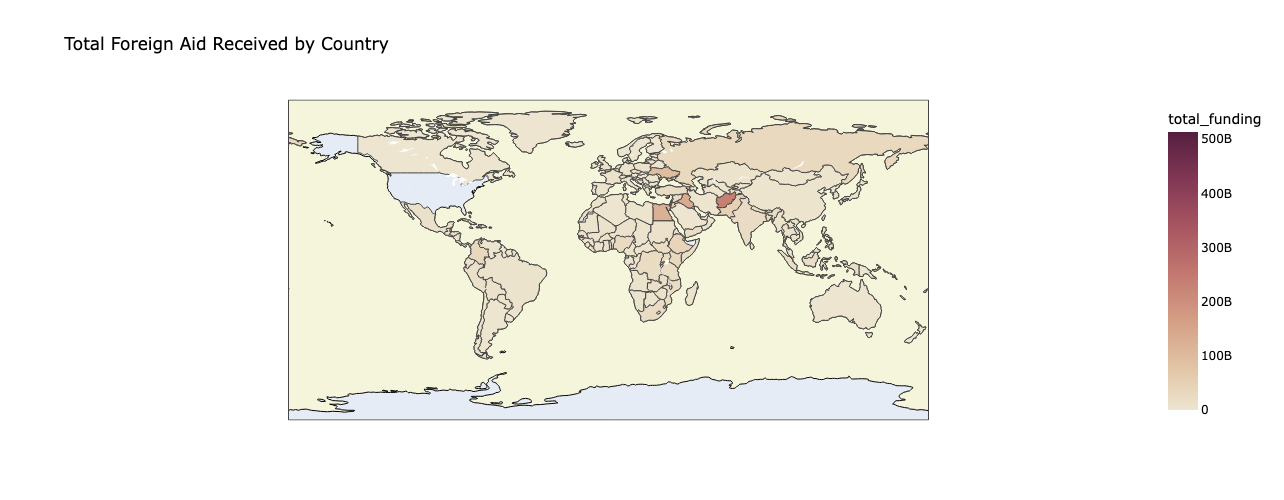

In [88]:
# Aggregate total funding per country and find top aid purpose
aid_map_data = aid2.groupby(['Country Name', 'Country Code'], as_index=False).agg(
    total_funding=('Current Dollar Amount', 'sum'),
    top_purpose=('International Purpose Name', lambda x: x.value_counts().idxmax())
)

# Create a larger choropleth map using Plotly Express with enhanced color sensitivity
fig = px.choropleth(
    aid_map_data,
    locations='Country Code',
    locationmode='ISO-3',
    color='total_funding',
    hover_name='Country Name',
    hover_data={'top_purpose': True, 'total_funding': True},
    color_continuous_scale='brwnyl',
    title="Total Foreign Aid Received by Country",
    width=800,
    height=500
)

# Set beige background and customize layout
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent background
    geo=dict(
        bgcolor="beige",  # Beige map background
        showframe=True,  # Hide map border
        showcoastlines=True,  # Keep coastlines
        coastlinecolor="black"
    ),
    font=dict(color="black")  # Ensure text is readable
)

# Export the interactive chart as an HTML file
fig.write_html("interactive_map.html")

fig.show()

In [94]:
# Load and prepare the data
df = pd.read_csv('us_foreign_aid_country.csv')

# Filter for European and Asian countries
europe_asia_df = df[df['Region Name'].isin(['Europe and Eurasia', 'South and Central Asia', 'East Asia and Oceania'])]

# Clean and convert Fiscal Year to integer
def clean_year(year_str):
    try:
        # Extract first 4 digits (removes any suffixes like 'tq')
        return int(str(year_str)[:4])
    except:
        return np.nan

europe_asia_df['Fiscal Year'] = europe_asia_df['Fiscal Year'].apply(clean_year)
europe_asia_df = europe_asia_df.dropna(subset=['Fiscal Year'])  # Remove rows with invalid years

# Aggregate by region and year
aid_by_region = europe_asia_df.groupby(['Region Name', 'Fiscal Year'])['current_amount'].sum().reset_index()

# Create radio button input for region selection
inputs = alt.binding_radio(options=aid_by_region['Region Name'].unique(), name='Region: ')
selection = alt.selection_point(fields=['Region Name'], bind=inputs, empty=False)

# Get min and max years for axis ticks
min_year = int(aid_by_region['Fiscal Year'].min())
max_year = int(aid_by_region['Fiscal Year'].max())
year_ticks = list(range(min_year, max_year + 1, 10))

# Create scatter plot of aid over time
scatter_plot = alt.Chart(aid_by_region).mark_circle(size=60).encode(
    x=alt.X('Fiscal Year:O', title='Year', axis=alt.Axis(values=year_ticks)),
    y=alt.Y('current_amount:Q', title='Aid Amount (USD)', scale=alt.Scale(type='log')),
    color=alt.condition(selection, 
                       alt.Color('Region Name:N', legend=None),
                       alt.value('lightgray')),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.1)),
    tooltip=['Region Name', 'Fiscal Year', 'current_amount']
).add_params(
    selection
).properties(
    width=800,
    height=400,
    title='A Comparison of US Foreign Aid Over Time by Region',
    background='transparent'
)

# Configure the chart
scatter_plot.configure_axis(
    labelAngle=45
).configure_view(
    strokeWidth=0
).configure_axisX(
    grid=False
).configure_axisY(
    grid=False
)

scatter_plot.save('regionscatter.html')

/var/folders/sw/xn5gpnrx02nc12s4xxynfpmm0000gn/T/ipykernel_24334/3472491717.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [93]:
from dash import Dash, dcc, html
from dash.dependencies import Input, Output

# Load the data
df = pd.read_csv('us_foreign_aid_funding.csv')

# Data cleaning and preparation
df = df[['Country Name', 'Funding Account Name', 'Transaction Type Name', 'Fiscal Year', 'current_amount']]
df = df[df['current_amount'] > 0]  # Remove negative values

# Categorize countries into the three specified regions
def assign_region(country):
    europe_eurasia = ['Albania', 'Armenia', 'Azerbaijan', 'Belarus', 'Bosnia and Herzegovina',
                     'Bulgaria', 'Croatia', 'Czechia', 'Estonia', 'Georgia', 'Hungary',
                     'Kazakhstan', 'Kosovo', 'Moldova', 'Montenegro', 'North Macedonia',
                     'Russia', 'Serbia', 'Ukraine']
    
    east_asia_oceania = ['China', 'Indonesia', 'Cambodia', 'Timor-Leste']
    
    south_central_asia = ['Afghanistan', 'Bangladesh', 'India', 'Pakistan']
    
    if country in europe_eurasia:
        return 'Europe & Eurasia'
    elif country in east_asia_oceania:
        return 'East Asia & Oceania'
    elif country in south_central_asia:
        return 'South & Central Asia'
    else:
        return None  # Will be filtered out

df['Region'] = df['Country Name'].apply(assign_region)
df = df[df['Region'].notna()]  # Keep only the three specified regions

# Categorize funding by sector
def assign_sector(account_name):
    account_name = str(account_name).lower()
    if 'capital' in account_name or 'investment' in account_name:
        return 'Infrastructure'
    elif 'stabilization' in account_name or 'security' in account_name:
        return 'Security'
    elif 'health' in account_name or 'medical' in account_name:
        return 'Health'
    elif 'education' in account_name or 'school' in account_name:
        return 'Education'
    elif 'aeeca' in account_name or 'democracy' in account_name or 'governance' in account_name:
        return 'Democracy & Governance'
    else:
        return 'Other'

df['Sector'] = df['Funding Account Name'].apply(assign_sector)

# Aggregate data
agg_df = df.groupby(['Region', 'Sector', 'Fiscal Year'])['current_amount'].sum().reset_index()

# Create Dash app
app = Dash(__name__)

app.layout = html.Div([
    html.H1("U.S. Foreign Aid to Key Regions (2004-2025)"),
    html.Div([
        dcc.Dropdown(
            id='year-range',
            options=[{'label': str(year), 'value': year} 
                    for year in sorted(df['Fiscal Year'].unique())],
            value=2023,
            multi=False,
            style={'width': '50%'}
        ),
        dcc.RadioItems(
            id='view-type',
            options=[
                {'label': 'Absolute Values (USD)', 'value': 'absolute'},
                {'label': 'Percentage Composition', 'value': 'percentage'}
            ],
            value='absolute',
            labelStyle={'display': 'inline-block', 'margin-right': '10px'}
        )
    ]),
    dcc.Graph(id='aid-chart'),
    html.Div([
        html.P("Explore U.S. foreign aid distribution across three key regions:"),
        html.Ul([
            html.Li("Europe & Eurasia"),
            html.Li("East Asia & Oceania"),
            html.Li("South & Central Asia")
        ]),
        html.P("Hover over bars to see detailed information about sector allocations.")
    ], style={'margin-top': '20px'})
])

@app.callback(
    Output('aid-chart', 'figure'),
    [Input('year-range', 'value'),
     Input('view-type', 'value')]
)
def update_chart(selected_year, view_type):
    filtered_df = agg_df[agg_df['Fiscal Year'] == selected_year]
    
    if view_type == 'percentage':
        # Calculate percentages
        total_by_region = filtered_df.groupby('Region')['current_amount'].transform('sum')
        filtered_df['percentage'] = (filtered_df['current_amount'] / total_by_region) * 100
        y_value = 'percentage'
        title = f'U.S. Foreign Aid by Sector ({selected_year}) - Percentage Composition'
        y_title = 'Percentage (%)'
    else:
        y_value = 'current_amount'
        title = f'U.S. Foreign Aid by Sector ({selected_year}) - USD Amounts'
        y_title = 'Amount (USD)'
    
    fig = px.bar(
        filtered_df,
        x='Region',
        y=y_value,
        color='Sector',
        title=title,
        labels={'current_amount': 'Amount (USD)', 'percentage': 'Percentage (%)'},
        hover_data=['current_amount'],
        color_discrete_sequence=px.colors.qualitative.Pastel
    )
    
    fig.update_layout(
        barmode='stack',
        xaxis={'categoryorder': 'total descending'},
        hovermode='x unified',
        height=600,
        yaxis_title=y_title,
        xaxis_title='Region'
    )
    
    if view_type == 'percentage':
        fig.update_yaxes(range=[0, 100])
    
    return fig

if __name__ == '__main__':
    app.run(debug=True)